be sure to be in environment: **Environment (conda_tensorflow_p27)**

In [38]:
import scipy.misc
import tensorflow as tf
import numpy as np
import time
from IPython.display import Image
from PIL import Image

from __future__ import print_function
from keras.preprocessing.image import load_img, img_to_array
from scipy.misc import imsave # to be able to save as an image
from scipy.optimize import fmin_l_bfgs_b # to optimize our cost function
import imageio

from keras.applications import vgg19 #to load vgg19 network
from keras import backend as K
import os

import keras
tf.__version__
keras.__version__

from keras.utils.vis_utils import plot_model #to be able to visualize the network
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

## Config and Hyperparameters for Model Tunning

In [61]:
'''
# change below to edit images and model params
'''
trial_name = 'fun'                                  # give this trial a name so all output files can be stored
content_file_name = 'cousins.jpg'                   # content image
style_file_name = 'trippy2.jpg'                     # style image
iterations = 13                                     # epochs during style fitting
total_variation_weight = 1.0                       # 
style_weight = 3.0                                 # weight assinged to style 
content_weight = 0.025                             # weight assinged to content
content_features = ['block3_conv4']                # feature for content image
style_features = ['block1_conv1',                  # features of the style image
                  'block2_conv1',
                  'block3_conv1', 
                  'block4_conv1',
                  'block5_conv1']

'''
# config definitions... do not change
'''
base_image_path = os.getcwd() + '/' + content_file_name
style_reference_image_path = os.getcwd() + '/' + style_file_name
img_nrows = 500  # scale the image to n pixel rows 
width, height = load_img(base_image_path).size 
img_ncols = int(width * img_nrows / height) # scale cols pixels

## Preview Style and Content Images

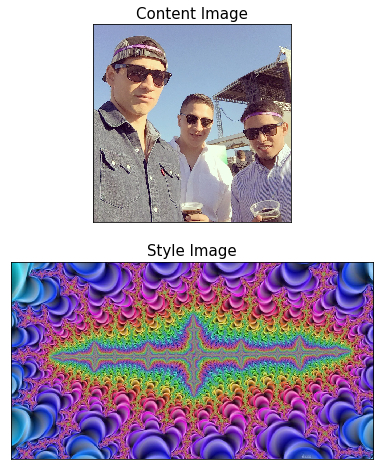

In [62]:
def preview_imgs():
    fontsize = 15
    fig, (ax1,ax2) = plt.subplots(2,1,figsize = (8,8))

    # image one 
    ax1.set_title('Content Image',fontsize=fontsize)
    ax1.imshow(load_img(base_image_path))
    ax1.set_yticks([])
    ax1.set_xticks([])

    # image 2
    ax2.set_title('Style Image',fontsize=fontsize)
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.imshow(load_img(style_reference_image_path))
    fig

plt.close('all')
preview_imgs()

## Image Preprocssing

In [63]:
'''
will rescale a image based based off the global definition of n_row and n_cols
and convert that image into a 3-D tensor for model purposes
'''
def preprocess_image(image_path):
    width, height = load_img(base_image_path).size
    img_ncols = int(width * img_nrows / height)
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img


# will convert a tensor into a valid image
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))

    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # 'BGR'->'RGB'

    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# will init the output page of style transfer to content
def init_combination_image():
    # this will contain our generated image
    if K.image_data_format() == 'channels_first':
        return K.placeholder((1, 3, img_nrows, img_ncols))
    else:
        return K.placeholder((1, img_nrows, img_ncols, 3))


    

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = init_combination_image()

# combine the 3 images (style, content, result image that starts from the white noise) into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

## Generate Model

In [64]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,weights='imagenet', include_top=False)

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

def write_layers(dct):
    fn = open(os.getcwd() + '/vgg19_layers.txt','w')

    for i in list(dct):
        fn.write(i)
        fn.write('\t')
        fn.write(str(dct[i]))
        fn.write('\n')
    fn.close()
write_layers(outputs_dict)
                                
for i in style_features:
    assert i in list(outputs_dict)

for j in content_features:
    assert j in list(outputs_dict)

## Loss Functions

In [65]:
# compute the neural style loss
# first we need to define 4 utility functions
# the gram matrix of an image tensor (feature-wise outer product)

def gram_matrix(x):

    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))

    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3

    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    return K.sum(K.square(combination - base))



# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent (no big changes)
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':

        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

loss = K.variable(0.)
layer_features = outputs_dict[content_features[0]]
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features,
                                      combination_features)
for layer_name in style_features:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_features)) * sl

loss += total_variation_weight * total_variation_loss(combination_image)

## Grandient Fucntions

In [66]:
# get the gradients of the generated image wrt the loss

grads = K.gradients(loss, combination_image)
outputs = [loss]

if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

def eval_loss_and_grads(x):

    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))

    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

## Run Model

In [67]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
evaluator = Evaluator()

In [ ]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)
os.mkdir(trial_name)

# minimise the loss function
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()

    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    
    # save current generated image
    img = deprocess_image(x.copy())
    fname = os.getcwd() +  '/' + trial_name + '/' + trial_name + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()

    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0


/Users/angelhernandez/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Image saved as /Users/angelhernandez/Documents/CMU/SP2019/MLArt/project1/fun/fun_at_iteration_0.png
Iteration 0 completed in 284s
Start of iteration 1
Image saved as /Users/angelhernandez/Documents/CMU/SP2019/MLArt/project1/fun/fun_at_iteration_1.png
Iteration 1 completed in 279s
Start of iteration 2
Image saved as /Users/angelhernandez/Documents/CMU/SP2019/MLArt/project1/fun/fun_at_iteration_2.png
Iteration 2 completed in 268s
Start of iteration 3
Image saved as /Users/angelhernandez/Documents/CMU/SP2019/MLArt/project1/fun/fun_at_iteration_3.png
Iteration 3 completed in 276s
Start of iteration 4


In [ ]:
#image_content= scipy.misc.imresize(image_content,(224,224))
plt.figure(figsize=(11,11))
plt.imshow(img)

In [ ]:
def generate_gif():
    fns = [i for i in os.listdir(trial_name) if i[-4:] in ['.png','.jpeg']]
    imgs = []
    
    for fn in fns:
        imgs.append(imageio.imread(os.getcwd() + '/' + trial_name + '/' + fn))
    
    imageio.mimsave(os.getcwd() + '/' + trial_name + '/' + trial_name + '.gif',imgs)
        
generate_gif()  